In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')  # Para limpiar la salida, pero con precaución

In [2]:
# 1. Carga y preparación inicial de datos
def load_and_prepare_data(filepath):
    """Carga los datos y realiza preparación inicial"""
    data = pd.read_csv(filepath, parse_dates=['Date'], dayfirst=True)
    data.set_index('Date', inplace=True)
    
    print("📊 Dimensiones del dataset:", data.shape)
    print("\n🔍 Primeras filas:")
    display(data.head(3))
    print("\n📝 Resumen estadístico:")
    display(data.describe().T)  # Transponemos para mejor visualización
    print("\nℹ️ Tipos de datos y valores faltantes:")
    print(data.info())
    
    return data

# Cargar datos
data = load_and_prepare_data('acea_data/Lake_Bilancino.csv')

📊 Dimensiones del dataset: (6603, 8)

🔍 Primeras filas:


,Rainfall_S_Piero,Rainfall_Mangona,Rainfall_S_Agata,Rainfall_Cavallina,Rainfall_Le_Croci,Temperature_Le_Croci,Lake_Level,Flow_Rate
Date,,,,,,,,
2002-06-03,NaN,NaN,NaN,NaN,NaN,NaN,249.43,0.31
2002-06-04,NaN,NaN,NaN,NaN,NaN,NaN,249.43,0.31
2002-06-05,NaN,NaN,NaN,NaN,NaN,NaN,249.43,0.31



📝 Resumen estadístico:


,count,mean,std,min,25%,50%,75%,max
Rainfall_S_Piero,6026.0,2.471225,6.650012,0.00,0.0,0.0,0.8,80.60
Rainfall_Mangona,6026.0,3.340657,8.903134,0.00,0.0,0.0,1.4,110.00
Rainfall_S_Agata,6026.0,2.670063,7.166643,0.00,0.0,0.0,1.2,120.20
Rainfall_Cavallina,6026.0,2.674743,7.655847,0.00,0.0,0.0,0.6,113.60
Rainfall_Le_Croci,6026.0,3.129871,8.025121,0.00,0.0,0.0,1.2,88.40
Temperature_Le_Croci,6025.0,14.530141,6.944029,-5.35,9.0,14.5,20.1,34.00
Lake_Level,6603.0,249.564091,2.172558,243.53,248.0,250.2,251.4,252.76
Flow_Rate,6582.0,2.760968,4.073428,0.31,0.6,1.5,3.0,74.65



ℹ️ Tipos de datos y valores faltantes:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6603 entries, 2002-06-03 to 2020-06-30
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Rainfall_S_Piero      6026 non-null   float64
 1   Rainfall_Mangona      6026 non-null   float64
 2   Rainfall_S_Agata      6026 non-null   float64
 3   Rainfall_Cavallina    6026 non-null   float64
 4   Rainfall_Le_Croci     6026 non-null   float64
 5   Temperature_Le_Croci  6025 non-null   float64
 6   Lake_Level            6603 non-null   float64
 7   Flow_Rate             6582 non-null   float64
dtypes: float64(8)
memory usage: 464.3 KB
None


In [3]:
data['Rainfall_Avg'] = data[['Rainfall_S_Piero', 'Rainfall_Mangona', 'Rainfall_S_Agata', 
                             'Rainfall_Cavallina', 'Rainfall_Le_Croci']].mean(axis=1)

data = data.rename(columns={'Temperature_Le_Croci': 'Temperature'})


In [4]:
data = data[['Rainfall_Avg', 'Temperature', 'Lake_Level', 'Flow_Rate']]

data

,Rainfall_Avg,Temperature,Lake_Level,Flow_Rate
Date,,,,
2002-06-03,NaN,NaN,249.43,0.31
2002-06-04,NaN,NaN,249.43,0.31
2002-06-05,NaN,NaN,249.43,0.31
2002-06-06,NaN,NaN,249.43,0.31
2002-06-07,NaN,NaN,249.44,0.31
...,...,...,...,...
2020-06-26,0.0,22.50,250.85,0.60
2020-06-27,0.0,23.40,250.84,0.60
2020-06-28,0.0,21.50,250.83,0.60


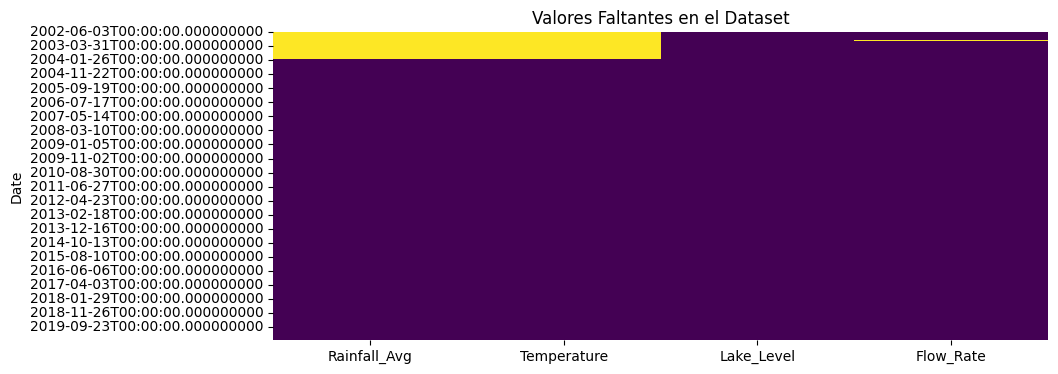

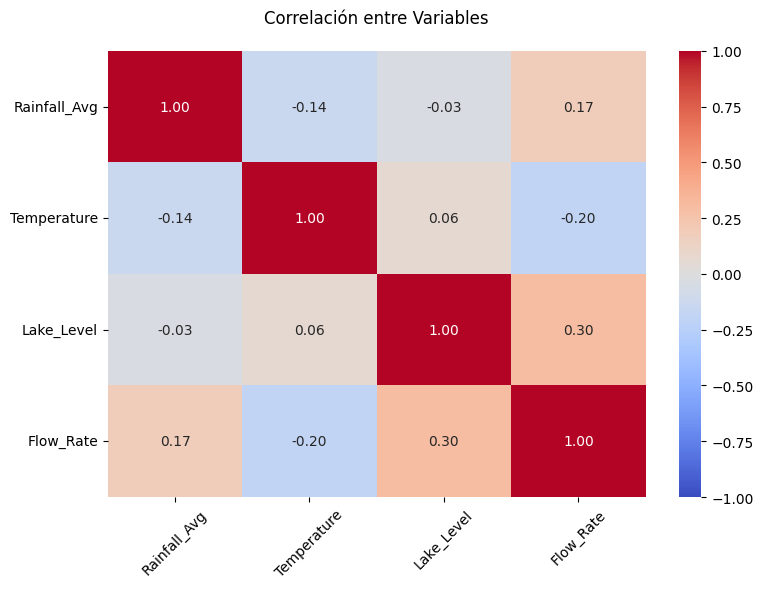

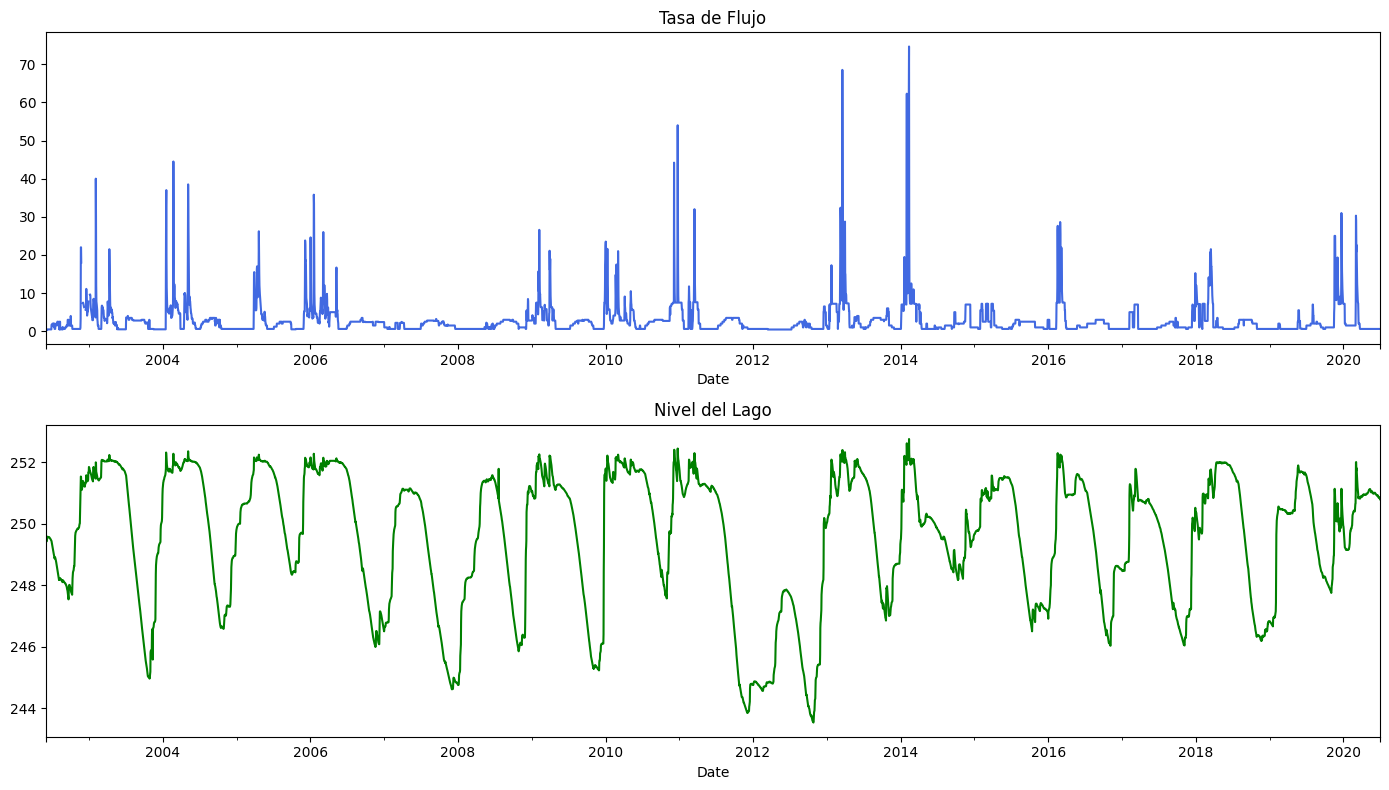

In [5]:
def exploratory_analysis(df):
    """Realiza análisis exploratorio visual"""
    # Visualización de valores faltantes
    plt.figure(figsize=(10, 4))
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
    plt.title('Valores Faltantes en el Dataset')
    plt.show()
    
    # Matriz de correlación
    corr = df.corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", 
                annot_kws={"size": 10}, vmin=-1, vmax=1)
    plt.title('Correlación entre Variables', pad=20)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Series temporales principales
    fig, axes = plt.subplots(2, 1, figsize=(14, 8))
    df['Flow_Rate'].plot(ax=axes[0], title='Tasa de Flujo', color='royalblue')
    df['Lake_Level'].plot(ax=axes[1], title='Nivel del Lago', color='green')
    plt.tight_layout()
    plt.show()

exploratory_analysis(data)

In [6]:
def preprocess_data(df):
    """Limpieza y transformación de datos"""
    # Manejo de valores faltantes
    df['Flow_Rate'] = df['Flow_Rate'].ffill().bfill()  # Forward y backward fill
    df['Lake_Level'] = df['Lake_Level'].interpolate(method='time')
    
    # Extracción de características temporales
    df['Year'] = df.index.year
    df['Month'] = df.index.month
    df['Day'] = df.index.day
    df['Day_of_week'] = df.index.dayofweek
    df['Day_of_year'] = df.index.dayofyear
    
    # Diferenciación para estacionaridad (opcional, dependiendo del modelo)
    # df['Flow_Rate_diff'] = df['Flow_Rate'].diff()
    
    return df[['Flow_Rate', 'Lake_Level', 'Year', 'Month']]  # Selección de variables relevantes

data_clean = preprocess_data(data.copy())

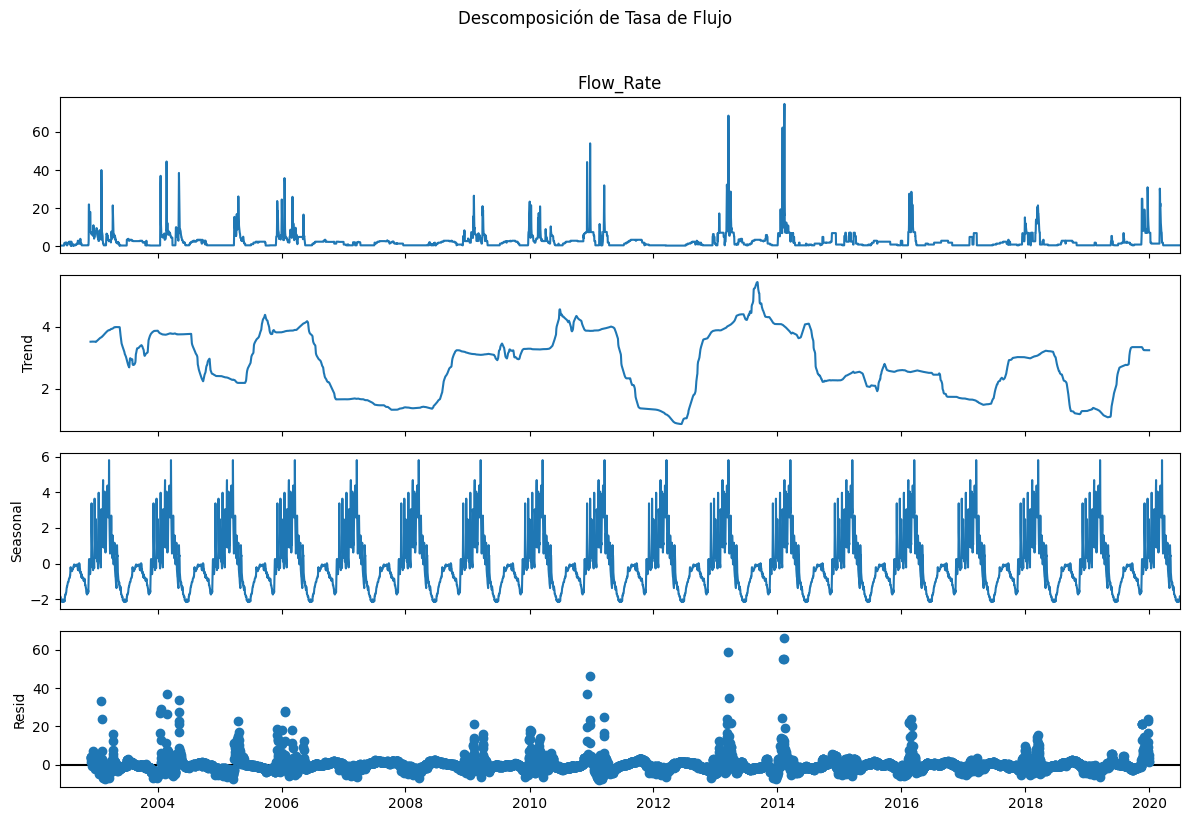

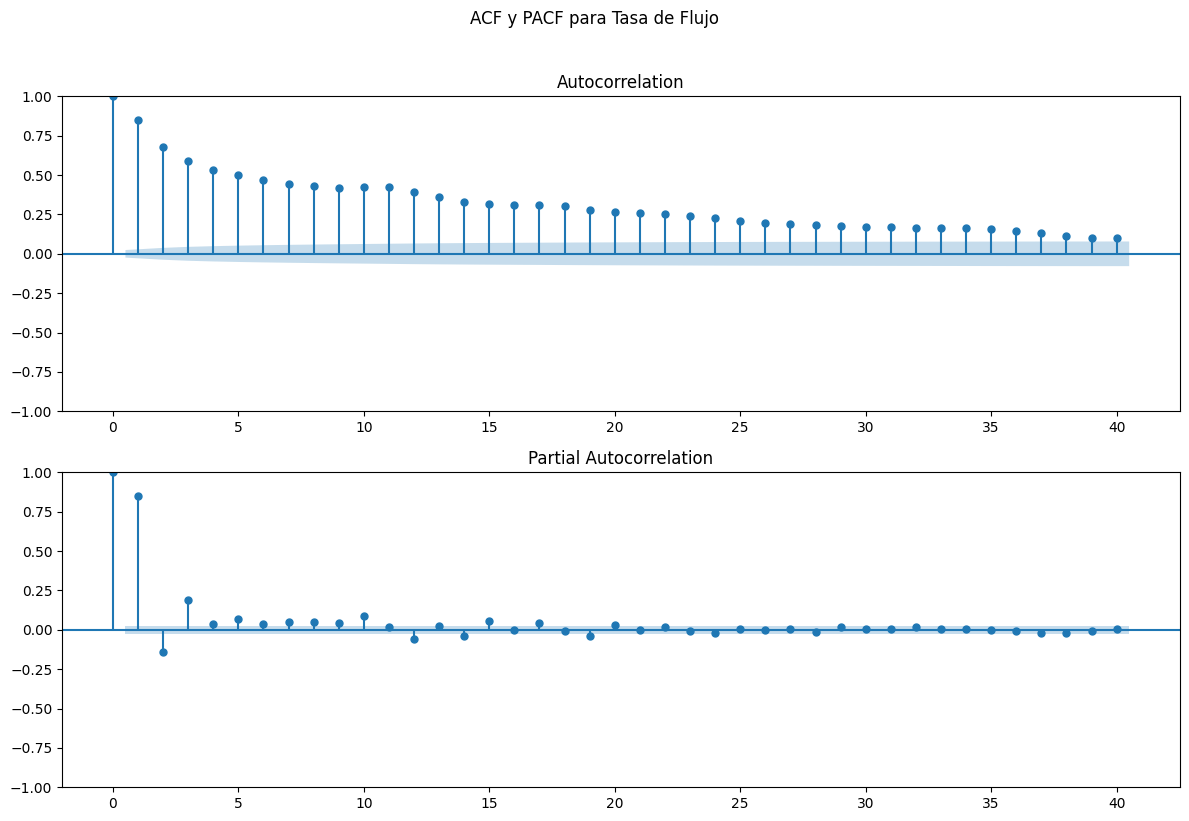

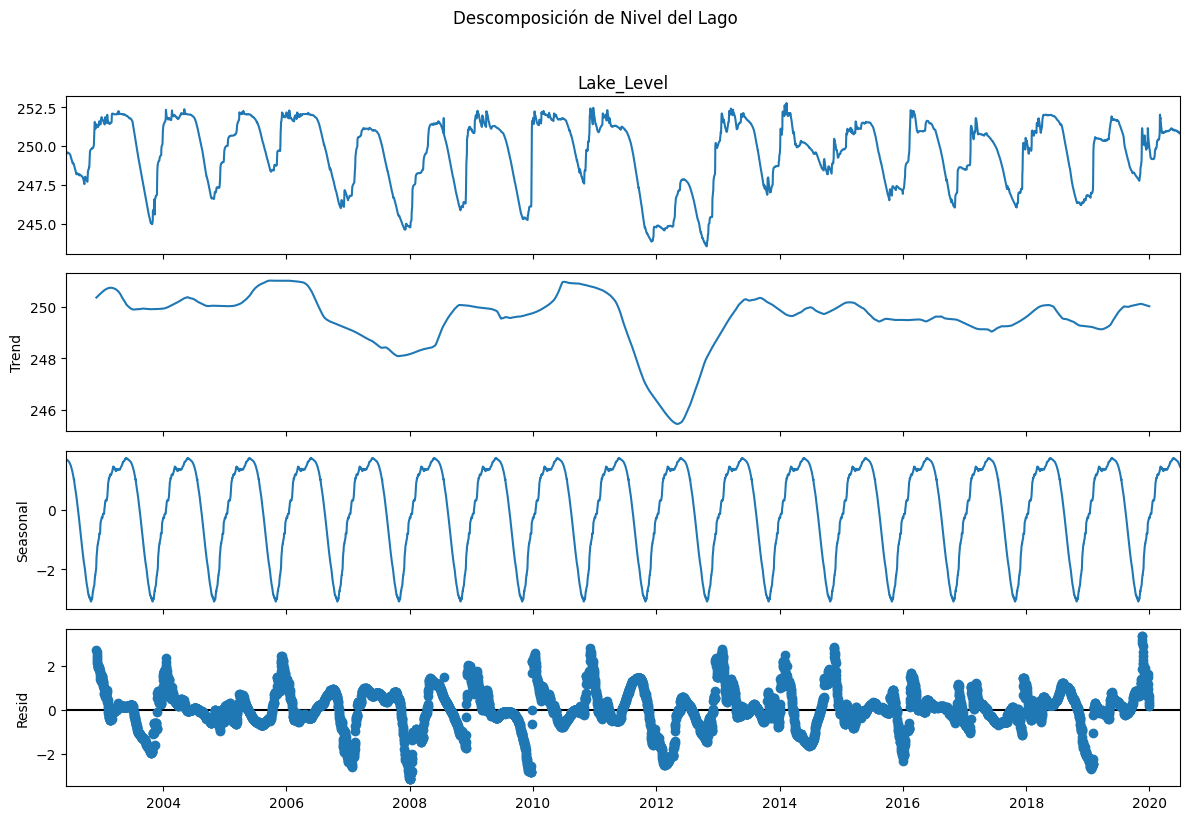

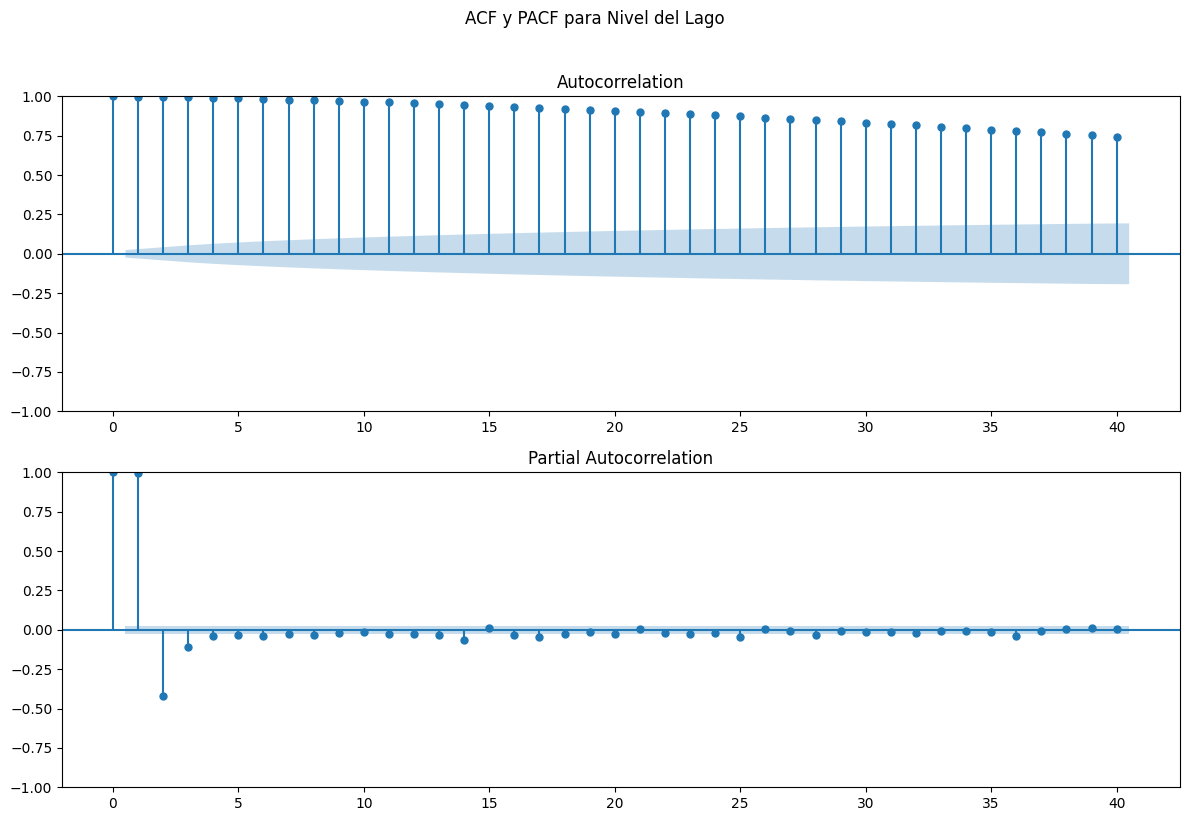

In [7]:
# 4. Análisis de series temporales
def time_series_analysis(series, title):
    """Análisis de componentes de series temporales"""
    # Descomposición
    result = seasonal_decompose(series.dropna(), model='additive', period=365)
    fig = result.plot()
    fig.set_size_inches(12, 8)
    fig.suptitle(f'Descomposición de {title}', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # ACF y PACF
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    plot_acf(series.dropna(), lags=40, ax=ax1)
    plot_pacf(series.dropna(), lags=40, ax=ax2)
    plt.suptitle(f'ACF y PACF para {title}', y=1.02)
    plt.tight_layout()
    plt.show()

time_series_analysis(data_clean['Flow_Rate'], 'Tasa de Flujo')
time_series_analysis(data_clean['Lake_Level'], 'Nivel del Lago')

In [8]:
print(data_clean.isnull().sum())

Flow_Rate     0
Lake_Level    0
Year          0
Month         0
dtype: int64


In [9]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries, name="Serie"):
    """Combina lo mejor de ambos métodos: formato de tabla + interpretación."""
    timeseries = timeseries.dropna()  # Elimina NaNs
    dftest = adfuller(timeseries, autolag="AIC")
    
    # Formato tabla (como en clases)
    dfoutput = pd.Series(dftest[0:4], index=[
        "Estadístico ADF", 
        "p-valor", 
        "Lags usados", 
        "Observaciones"
    ])
    for key, value in dftest[4].items():
        dfoutput[f"Valor crítico ({key})"] = value
    
    # Interpretación automática (como en mi versión)
    print(f"\n🔍 Resultados ADF para {name}:")
    print("✅ Conclusión: La serie ES estacionaria (p ≤ 0.05)" if dftest[1] <= 0.05 
          else "❌ Conclusión: La serie NO es estacionaria (p > 0.05)")
    
    return dfoutput  # Devuelve la Serie por si quieres usarla después

In [10]:
# Aplicar a Flow_Rate
ts_flow_rate = data_clean['Flow_Rate'].dropna()
test_stationarity(ts_flow_rate, 'Flow_Rate')




🔍 Resultados ADF para Flow_Rate:
✅ Conclusión: La serie ES estacionaria (p ≤ 0.05)


Estadístico ADF       -1.058731e+01
p-valor                6.665515e-19
Lags usados            1.900000e+01
Observaciones          6.583000e+03
Valor crítico (1%)    -3.431344e+00
Valor crítico (5%)    -2.861979e+00
Valor crítico (10%)   -2.567004e+00
dtype: float64

In [11]:
# Aplicar a Lake_Level
ts_lake_level = data_clean['Lake_Level'].dropna()
test_stationarity(ts_lake_level, 'Lake_Level')


🔍 Resultados ADF para Lake_Level:
✅ Conclusión: La serie ES estacionaria (p ≤ 0.05)


Estadístico ADF       -6.880991e+00
p-valor                1.433634e-09
Lags usados            3.500000e+01
Observaciones          6.567000e+03
Valor crítico (1%)    -3.431346e+00
Valor crítico (5%)    -2.861980e+00
Valor crítico (10%)   -2.567004e+00
dtype: float64

In [12]:
from pmdarima import auto_arima

model_lake_level = auto_arima(ts_lake_level.dropna(),
    start_p=1, start_q=1,  # Reduce rangos iniciales
    max_p=3, max_q=3,      # Limita parámetros máximos
    d=1,                   # Fija diferenciación (evita búsqueda automática)
    seasonal=False,         # Desactiva estacionalidad inicialmente
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    n_jobs=1               # Usa solo 1 núcleo de CPU
)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-12554.341, Time=4.00 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-11118.435, Time=0.35 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-12469.605, Time=0.70 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-12130.639, Time=1.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-11120.409, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-12603.723, Time=5.70 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-12541.146, Time=1.26 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-12618.202, Time=6.93 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-12549.062, Time=4.03 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-12608.086, Time=7.69 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-12552.739, Time=3.97 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-12622.848, Time=3.24 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-12605.724, Time=1.82 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-12551.055, Time=0.87 sec
 ARIM

In [13]:
model_lake_level.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 6603
Model:               SARIMAX(3, 1, 1)   Log Likelihood                6316.424
Date:                Wed, 23 Apr 2025   AIC                         -12622.848
Time:                        02:09:52   BIC                         -12588.873
Sample:                    06-03-2002   HQIC                        -12611.106
                         - 06-30-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3067      0.011    122.887      0.000       1.286       1.328
ar.L2         -0.2670      0.006    -47.348      0.000      -0.278      -0.256
ar.L3         -0.0567      0.005    -12.437      0.000      -0.066      -0.048
ma.L1         -0.9376      0.011    -85.496      0.000      -0.959      -0.916
sigma2         0.0086   2.47e-05    350.020      0.000       0.009       0.009
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           2213010.74
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.56   Skew:                             5.75
Prob(H) (two-sided):                  0.00   Kurtosis:                        91.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

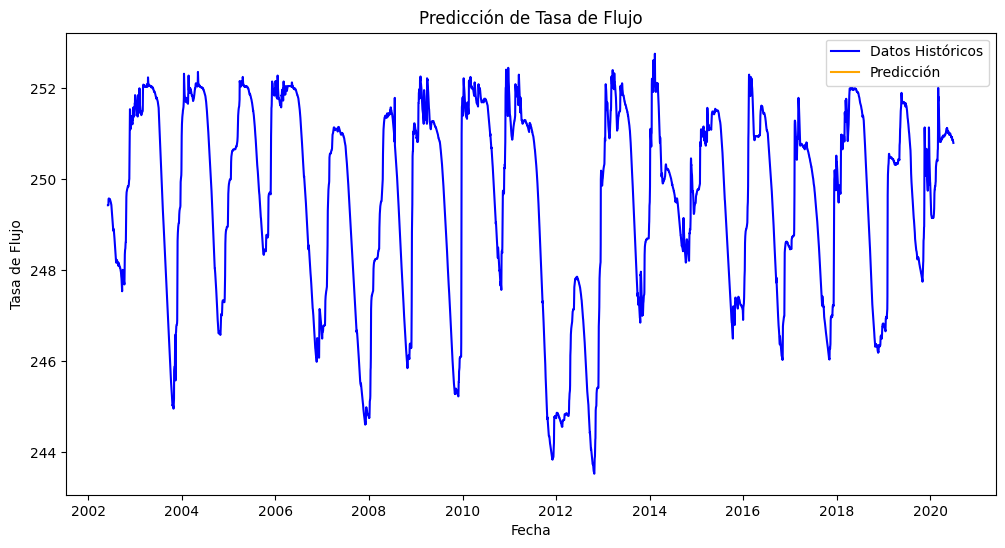

In [14]:
forecast_lake_level = model_lake_level.predict(n_periods=12)
forecast_lake_level = pd.Series(forecast_lake_level, 
                                 index=pd.date_range(start=ts_lake_level.index[-1] + pd.Timedelta(days=1), 
                                                     periods=12, freq='M'))
forecast_lake_level
# Visualización de la predicción
plt.figure(figsize=(12, 6))
plt.plot(ts_lake_level, label='Datos Históricos', color='blue')
plt.plot(forecast_lake_level, label='Predicción', color='orange')
plt.title('Predicción de Tasa de Flujo')
plt.xlabel('Fecha')
plt.ylabel('Tasa de Flujo')
plt.legend()
plt.show()